In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds

from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
epochs = 20
batch_size = 128
learning_rate = 1e-4

# Load Data

In [3]:
(training_set, validation_set), dataset_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:70%]', 'train[70%:]'],
    with_info=True,
    as_supervised=True,
)

In [4]:
index_label = dict([(index, label) for index, label in enumerate(dataset_info.features['label'].names)])

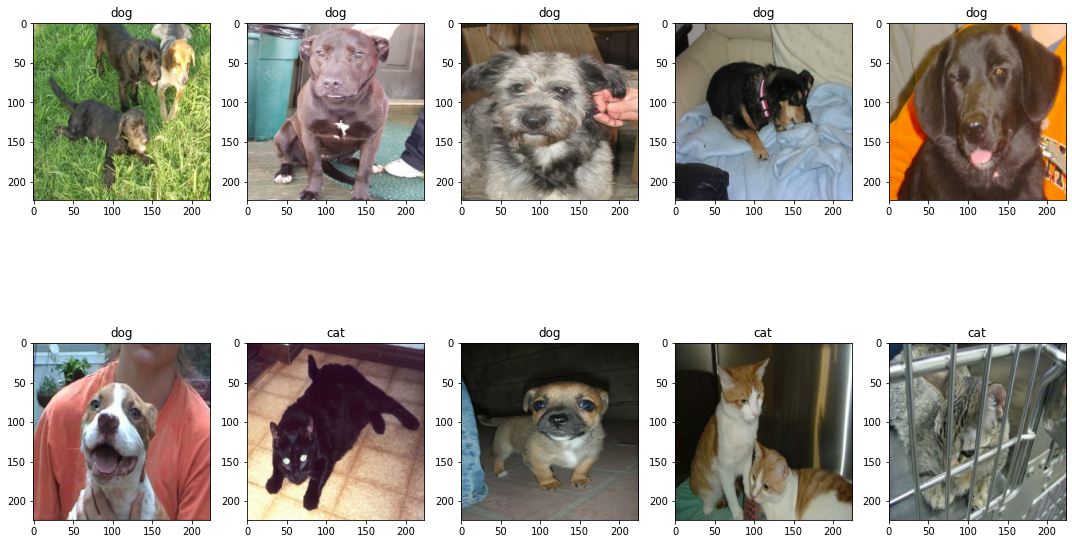

In [5]:
row, column, count = 2, 5, 0
plt.figure(figsize=(15, 10))
images = []
for image, label in validation_set.shuffle(10).take(10):
  count += 1
  images.append(image)
  plt.subplot(row, column, count)
  plt.title(index_label[label.numpy()])
  image = tf.image.resize(image, [224, 224])
  image = tf.cast(image, tf.uint8)
  plt.imshow(image)

plt.tight_layout()

In [6]:
@tf.function
def norm_image(image, label):
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, [224, 224])
  image = image / 255.
  return image, tf.one_hot(label, 2)

In [7]:
training_set = training_set\
              .shuffle(1024)\
              .map(norm_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)\
              .batch(batch_size)\
              .prefetch(tf.data.experimental.AUTOTUNE)

validation_set = validation_set\
              .map(norm_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)\
              .batch(batch_size)\
              .prefetch(tf.data.experimental.AUTOTUNE)

# Build Model

In [44]:
def create_model(head_type='standard'):
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.InputLayer(input_shape=(224, 224, 3)))
  model.add(tf.keras.layers.Conv2D(32, (3, 3)))
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.MaxPooling2D((2, 2)))
  model.add(tf.keras.layers.Activation('relu'))

  model.add(tf.keras.layers.Conv2D(64, (3, 3)))
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.MaxPooling2D((2, 2)))
  model.add(tf.keras.layers.Activation('relu'))

  model.add(tf.keras.layers.Conv2D(128, (3, 3)))
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.MaxPooling2D((2, 2)))
  model.add(tf.keras.layers.Activation('relu'))

  if head_type == 'standard':
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(256))
    model.add(tf.keras.layers.Activation('relu'))
    model.add(tf.keras.layers.Dropout(0.2))
  elif head_type == 'average':
    model.add(tf.keras.layers.GlobalAveragePooling2D())
    model.add(tf.keras.layers.Dense(256))
    model.add(tf.keras.layers.Activation('relu'))
    model.add(tf.keras.layers.Dropout(0.2))

  model.add(tf.keras.layers.Dense(2))
  model.add(tf.keras.layers.Activation('softmax'))
  return model

In [45]:
model = create_model(head_type='average')
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 222, 222, 32)      896       
_________________________________________________________________
batch_normalization_9 (Batch (None, 222, 222, 32)      128       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
activation_13 (Activation)   (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 109, 109, 64)      18496     
_________________________________________________________________
batch_normalization_10 (Batc (None, 109, 109, 64)      256       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 54, 54, 64)       

# Training 

In [46]:
early_stopping = tf.keras.callbacks.EarlyStopping(patience=3, monitor='val_accuracy', min_delta=0.001)

In [ ]:
model_logs = {}

for model_type in ['standard', 'average']:
  model = create_model(head_type=model_type)
  model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), metrics=['accuracy'])
  history = model.fit(training_set, validation_data=validation_set, epochs=epochs, callbacks=[early_stopping])
  model_logs[model_type + '_logs'] = history.history

Epoch 1/20
128/128 [==============================] - 38s 287ms/step - loss: 0.7542 - accuracy: 0.6561 - val_loss: 0.7309 - val_accuracy: 0.4962
Epoch 2/20
128/128 [==============================] - 37s 281ms/step - loss: 0.5157 - accuracy: 0.7442 - val_loss: 0.6925 - val_accuracy: 0.5306
Epoch 3/20
128/128 [==============================] - 37s 287ms/step - loss: 0.4640 - accuracy: 0.7777 - val_loss: 0.5915 - val_accuracy: 0.6770
Epoch 4/20
128/128 [==============================] - 37s 285ms/step - loss: 0.4269 - accuracy: 0.8057 - val_loss: 0.5064 - val_accuracy: 0.7487
Epoch 5/20
128/128 [==============================] - 37s 286ms/step - loss: 0.3952 - accuracy: 0.8225 - val_loss: 0.4576 - val_accuracy: 0.7806
Epoch 6/20
128/128 [==============================] - 37s 285ms/step - loss: 0.3567 - accuracy: 0.8418 - val_loss: 0.4352 - val_accuracy: 0.7921
Epoch 7/20
128/128 [==============================] - 37s 286ms/step - loss: 0.3431 - accuracy: 0.8500 - val_loss: 0.4245 - val_ac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Adding an axes using the s

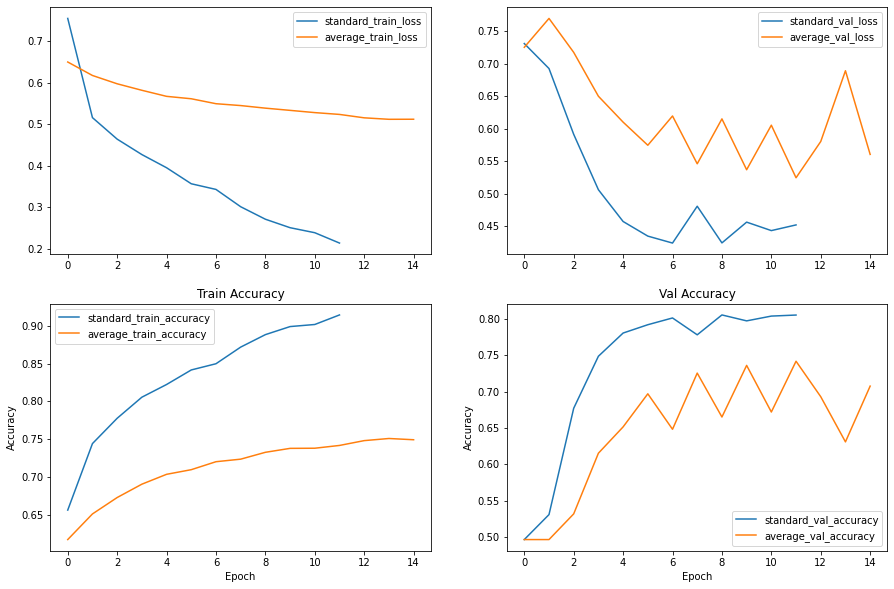

In [50]:
plt.figure(figsize=(15, 10))
for model_type in ['standard', 'average']:
  plt.subplot(221)
  plt.plot(model_logs[model_type + '_logs']['loss'], label=model_type + '_train_loss')
  plt.legend()

  plt.subplot(222)
  plt.plot(model_logs[model_type + '_logs']['val_loss'], label=model_type + '_val_loss')
  plt.legend()

  ax3 = plt.subplot(223)
  ax3.set_title('Train Accuracy')
  ax3.set_xlabel('Epoch')
  ax3.set_ylabel('Accuracy')
  ax3.plot(model_logs[model_type + '_logs']['accuracy'], label=model_type + '_train_accuracy')
  ax3.legend()

  ax4 = plt.subplot(224)
  ax4.set_title('Val Accuracy')
  ax4.set_xlabel('Epoch')
  ax4.set_ylabel('Accuracy')
  ax4.plot(model_logs[model_type + '_logs']['val_accuracy'], label=model_type + '_val_accuracy')
  ax4.legend()

In [ ]:
model.evaluate(validation_set)[1]

# Plot Precision Recall Curve

In [66]:
from sklearn.metrics import precision_recall_curve, average_precision_score, auc

In [54]:
y_true = []
for image, label in validation_set:
  y_true.append(label.numpy())

y_true = np.concatenate(y_true).argmax(axis=1)

In [55]:
y_pred = model.predict(validation_set).argmax(axis=1)

In [59]:
precision, recall, thresholds = precision_recall_curve(y_true, y_pred)

mAP: 0.6858684242783328
Auc: 0.8114117697297532


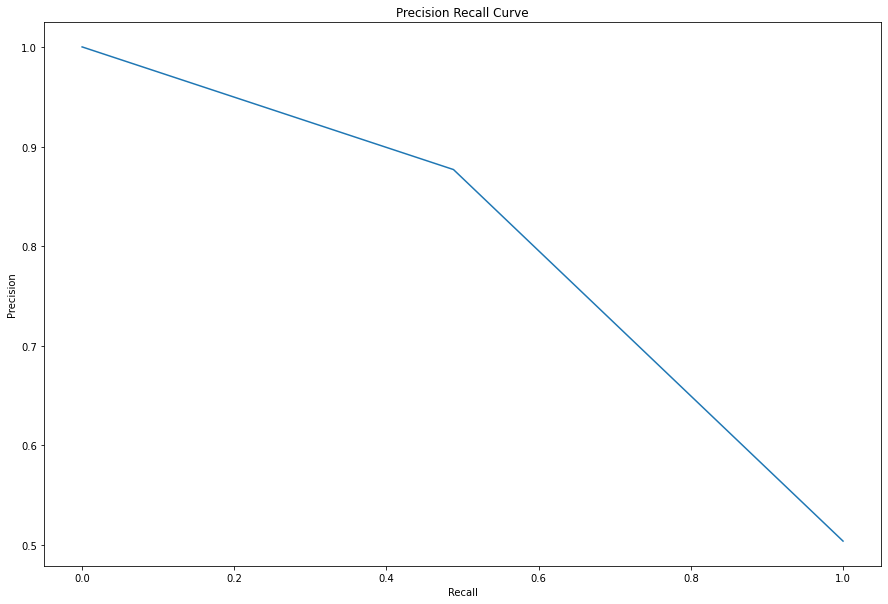

In [67]:
plt.figure(figsize=(15, 10))
plt.title('Precision Recall Curve')
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
print('mAP: {}'.format(average_precision_score(y_true, y_pred)))
print('Auc: {}'.format(auc(recall, precision)))